In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_google_genai langgraph_sdk serpapi sendgrid langchain_openai


In [3]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KET')
SERPAPI_API_KEY = userdata.get('SERPAPI_API_KEY')
SENDGRID_API_KEY = userdata.get('SENDGRID_API_KEY')
open_api_key = userdata.get('OPENAI_API_KEY')

In [4]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [48]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", api_key=open_api_key)
llm.invoke("greet me")



AIMessage(content='Hello! How are you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 10, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'stop', 'logprobs': None}, id='run-302b7f62-a7c0-40b5-b88b-1fe4011b9f20-0', usage_metadata={'input_tokens': 10, 'output_tokens': 8, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [49]:
from typing import TypedDict, Annotated, List
from langgraph.graph import MessagesState
from langchain_core.prompts import ChatPromptTemplate

In [50]:
from langgraph.graph import MessagesState
class AgentState(MessagesState):
    pass



In [51]:
import datetime
import operator

CURRENT_YEAR = datetime.datetime.now().year

# TOOLS_SYSTEM_PROMPT = f"""You are a smart travel agency. Use the tools to look up information.
#     You are allowed to make multiple calls (either together or in sequence).
#     Only look up information when you are sure of what you want.
#     The current year is {CURRENT_YEAR}.
#     If you need to look up some information before asking a follow up question, you are allowed to do that!
#     I want to have in your output links to hotels websites and flights websites (if possible).
#     I want to have as well the logo of the hotel and the logo of the airline company (if possible).
#     In your output always include the price of the flight and the price of the hotel and the currency as well (if possible).
#     for example for hotels-
#     Rate: $581 per night
#     Total: $3,488
#     """

TOOLS_SYSTEM_PROMPT = f"""You are a smart travel agency specializing in Pakistan tourism.
    You provide travel options only for domestic travel within Pakistan.
    Use the tools to look up information on hotels and flights available in Pakistan.
    If a user requests travel outside Pakistan, politely inform them that you only support domestic options.
    The current year is {CURRENT_YEAR}.
    If you need to look up some information before asking a follow up question, you are allowed to do that!
    I want to have in your output links to hotels websites and flights websites (if possible).
    I want to have as well the logo of the hotel and the logo of the airline company (if possible).
    In your output always include the price of the flight and the price of the hotel and the currency as well (if possible).
    For example, for hotels:
    Rate: Rs 50000 per night
    Total: Rs 30,488
    """

EMAILS_SYSTEM_PROMPT = """Your task is to convert structured markdown-like text into a valid HTML email body.

- Do not include a ```html preamble in your response.
- The output should be in proper HTML format, ready to be used as the body of an email.
Here is an example:
<example>
Input:

I want to travel to New York from Madrid from October 1-7. Find me flights and 4-star hotels.

Expected Output:

<!DOCTYPE html>
<html>
<head>
    <title>Flight and Hotel Options</title>
</head>
<body>
    <h2>Flights from Madrid to New York</h2>
    <ol>
        <li>
            <strong>American Airlines</strong><br>
            <strong>Departure:</strong> Adolfo Suárez Madrid–Barajas Airport (MAD) at 10:25 AM<br>
            <strong>Arrival:</strong> John F. Kennedy International Airport (JFK) at 12:25 PM<br>
            <strong>Duration:</strong> 8 hours<br>
            <strong>Aircraft:</strong> Boeing 777<br>
            <strong>Class:</strong> Economy<br>
            <strong>Price:</strong> $702<br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/AA.png" alt="American Airlines"><br>
            <a href="https://www.google.com/flights">Book on Google Flights</a>
        </li>
        <li>
            <strong>Iberia</strong><br>
            <strong>Departure:</strong> Adolfo Suárez Madrid–Barajas Airport (MAD) at 12:25 PM<br>
            <strong>Arrival:</strong> John F. Kennedy International Airport (JFK) at 2:40 PM<br>
            <strong>Duration:</strong> 8 hours 15 minutes<br>
            <strong>Aircraft:</strong> Airbus A330<br>
            <strong>Class:</strong> Economy<br>
            <strong>Price:</strong> $702<br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/IB.png" alt="Iberia"><br>
            <a href="https://www.google.com/flights">Book on Google Flights</a>
        </li>
        <li>
            <strong>Delta Airlines</strong><br>
            <strong>Departure:</strong> Adolfo Suárez Madrid–Barajas Airport (MAD) at 10:00 AM<br>
            <strong>Arrival:</strong> John F. Kennedy International Airport (JFK) at 12:30 PM<br>
            <strong>Duration:</strong> 8 hours 30 minutes<br>
            <strong>Aircraft:</strong> Boeing 767<br>
            <strong>Class:</strong> Economy<br>
            <strong>Price:</strong> $738<br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/DL.png" alt="Delta Airlines"><br>
            <a href="https://www.google.com/flights">Book on Google Flights</a>
        </li>
    </ol>

    <h2>4-Star Hotels in New York</h2>
    <ol>
        <li>
            <strong>NobleDen Hotel</strong><br>
            <strong>Description:</strong> Modern, polished hotel offering sleek rooms, some with city-view balconies, plus free Wi-Fi.<br>
            <strong>Location:</strong> Near Washington Square Park, Grand St, and JFK Airport.<br>
            <strong>Rate per Night:</strong> $537<br>
            <strong>Total Rate:</strong> $3,223<br>
            <strong>Rating:</strong> 4.8/5 (656 reviews)<br>
            <strong>Amenities:</strong> Free Wi-Fi, Parking, Air conditioning, Restaurant, Accessible, Business centre, Child-friendly, Smoke-free property<br>
            <img src="https://lh5.googleusercontent.com/p/AF1QipNDUrPJwBhc9ysDhc8LA822H1ZzapAVa-WDJ2d6=s287-w287-h192-n-k-no-v1" alt="NobleDen Hotel"><br>
            <a href="http://www.nobleden.com/">Visit Website</a>
        </li>
        <!-- More hotel entries here -->
    </ol>
</body>
</html>

</example>


"""

In [52]:
from langchain_core.tools import tool

from typing import Optional

from pydantic import BaseModel, Field
import serpapi
# from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool


# class FlightsInput(BaseModel):
#     departure_airport: Optional[str] = Field(description='Departure airport code (IATA)')
#     arrival_airport: Optional[str] = Field(description='Arrival airport code (IATA)')
#     outbound_date: Optional[str] = Field(description='Outbound date in YYYY-MM-DD format, e.g. 2024-06-22')
#     return_date: Optional[str] = Field(description='Return date in YYYY-MM-DD format, e.g. 2024-06-28')
#     adults: Optional[int] = Field(1, description='Number of adults (default 1)')
#     children: Optional[int] = Field(0, description='Number of children (default 0)')
#     infants_in_seat: Optional[int] = Field(0, description='Number of infants in seat (default 0)')
#     infants_on_lap: Optional[int] = Field(0, description='Number of infants on lap (default 0)')

# class FlightsInputSchema(BaseModel):
#     params: FlightsInput

# @tool(args_schema=FlightsInputSchema)
# def flights_finder(params: FlightsInput):
#     '''
#     Find flights using the Google Flights engine for domestic travel within Pakistan.
#     '''
#     # Define valid Pakistan airport codes (expand as needed)
#     pakistan_airports = {"ISB" , "KDU", "KHI", "LHE", "PEW", "MUX"}
#     if params.departure_airport not in pakistan_airports or params.arrival_airport not in pakistan_airports:
#          return "Error: This agent only supports domestic flights within Pakistan. Please provide valid Pakistan airport codes (e.g., ISB, KDU, KHI, LHE, PEW )."

#     search_params = {
#         'api_key': SERPAPI_API_KEY,
#         'engine': 'google_flights',
#         'hl': 'en',
#         'gl': 'pk',  # Limit search to Pakistan
#         'departure_id': params.departure_airport,
#         'arrival_id': params.arrival_airport,
#         'outbound_date': params.outbound_date,
#         'return_date': params.return_date,
#         'currency': 'PKR',  # Pakistani Rupees
#         'adults': params.adults,
#         'infants_in_seat': params.infants_in_seat,
#         'stops': '1',
#         'infants_on_lap': params.infants_on_lap,
#         'children': params.children
#     }

#     try:
#         search = serpapi.search(search_params)
#         results = search.data['best_flights']
#     except Exception as e:
#         results = str(e)
#     return results


class FlightsInput(BaseModel):
    departure_airport: Optional[str] = Field(description='Departure airport code (IATA)')
    arrival_airport: Optional[str] = Field(description='Arrival airport code (IATA)')
    outbound_date: Optional[str] = Field(description='Parameter defines the outbound date. The format is YYYY-MM-DD. e.g. 2024-06-22')
    return_date: Optional[str] = Field(description='Parameter defines the return date. The format is YYYY-MM-DD. e.g. 2024-06-28')
    adults: Optional[int] = Field(1, description='Parameter defines the number of adults. Default to 1.')
    children: Optional[int] = Field(0, description='Parameter defines the number of children. Default to 0.')
    infants_in_seat: Optional[int] = Field(0, description='Parameter defines the number of infants in seat. Default to 0.')
    infants_on_lap: Optional[int] = Field(0, description='Parameter defines the number of infants on lap. Default to 0.')


class FlightsInputSchema(BaseModel):
    params: FlightsInput


@tool(args_schema=FlightsInputSchema)
def flights_finder(params: FlightsInput):
    '''
    Find flights using the Google Flights engine.

    Returns:
        dict: Flight search results.
    '''

    params = {
        'api_key': SERPAPI_API_KEY,
        'engine': 'google_flights',
        'hl': 'en',
        'gl': 'pk',
        'departure_id': params.departure_airport,
        'arrival_id': params.arrival_airport,
        'outbound_date': params.outbound_date,
        'return_date': params.return_date,
        'currency': 'PKR',
        'adults': params.adults,
        'infants_in_seat': params.infants_in_seat,
        'stops': '1',
        'infants_on_lap': params.infants_on_lap,
        'children': params.children
    }

    try:
        search = serpapi.search(params)
        results = search.data['best_flights']
    except Exception as e:
        results = str(e)
    return results

In [53]:
class HotelsInput(BaseModel):
    q: str = Field(description='Location of the hotel')
    check_in_date: str = Field(description='Check-in date. The format is YYYY-MM-DD. e.g. 2024-06-22')
    check_out_date: str = Field(description='Check-out date. The format is YYYY-MM-DD. e.g. 2024-06-28')
    sort_by: Optional[str] = Field(8, description='Parameter is used for sorting the results. Default is sort by highest rating')
    adults: Optional[int] = Field(1, description='Number of adults. Default to 1.')
    children: Optional[int] = Field(0, description='Number of children. Default to 0.')
    rooms: Optional[int] = Field(1, description='Number of rooms. Default to 1.')
    hotel_class: Optional[str] = Field(
        None, description='Parameter defines to include only certain hotel class in the results. for example- 2,3,4')


class HotelsInputSchema(BaseModel):
    params: HotelsInput


@tool(args_schema=HotelsInputSchema)
def hotels_finder(params: HotelsInput):
    '''
    Find hotels using the Google Hotels engine.

    Returns:
        dict: Hotel search results.
    '''
    print(f"calling...")



    params = {
        'api_key': SERPAPI_API_KEY,
        'engine': 'google_hotels',
        'hl': 'en',
        'gl': 'pk',
        'q': params.q,
        'check_in_date': params.check_in_date,
        'check_out_date': params.check_out_date,
        'currency': 'PKR',
        'adults': params.adults,
        'children': params.children,
        'rooms': params.rooms,
        'sort_by': params.sort_by,
        'hotel_class': params.hotel_class
    }
    print(f"calling again...")

    search = serpapi.search(params)
    results = search.data
    print(f"hotels results",results)
    return results['properties'][:5]

In [54]:
tools: list[tool] = [flights_finder, hotels_finder]

llm_with_tools = llm.bind_tools(tools)

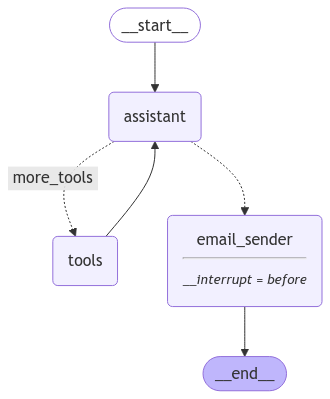

In [56]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, END ,START
from IPython.display import display, Image
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail


def assistant(state: AgentState):
        messages = state['messages']
        messages = [SystemMessage(content=TOOLS_SYSTEM_PROMPT)] + messages
        message = llm_with_tools.invoke(messages)
        return {'messages': [message]}

# def invoke_tools(self, state: AgentState):
#         tool_calls = state['messages'][-1].tool_calls
#         results = []
#         for t in tool_calls:
#             print(f'Calling: {t}')
#             if not t['name'] in self._tools:  # check for bad tool name from LLM
#                 print('\n ....bad tool name....')
#                 result = 'bad tool name, retry'  # instruct LLM to retry if bad
#             else:
#                 result = self._tools[t['name']].invoke(t['args'])
#             results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
#         print('Back to the model!')
#         return {'messages': results}

def exists_action(state: AgentState):
        result = state['messages'][-1]
        if len(result.tool_calls) == 0:
            return 'email_sender'
        return 'more_tools'


def email_sender(state: AgentState):
        print('Sending email')
        # email_llm = ChatOpenAI(model='gpt-4o', temperature=0.1)  # Instantiate another LLM
        email_message = [SystemMessage(content=EMAILS_SYSTEM_PROMPT), HumanMessage(content=state['messages'][-1].content)]
        email_response = llm.invoke(email_message)
        print('Email content:', email_response.content)

        # message = Mail(from_email=os.environ['FROM_EMAIL'], to_emails=os.environ['TO_EMAIL'], subject=os.environ['EMAIL_SUBJECT'],
        #                html_content=email_response.content)

        message = Mail(from_email="areeb.ahmed.langgraph@gmail.com", to_emails="areebahmed575@gmail.com", subject="Static Email Subject",
                       html_content=email_response.content)


        try:
            sg = SendGridAPIClient(SENDGRID_API_KEY)
            response = sg.send(message)
            print(response.status_code)
            print(response.body)
            print(response.headers)
        except Exception as e:
            print(str(e))





# Graph
builder: StateGraph = StateGraph(MessagesState)


# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node('email_sender', email_sender)

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
# builder.add_conditional_edges(
#     "assistant",
#     # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
#     tools_condition,
# )
builder.add_conditional_edges('assistant', exists_action, {'more_tools': 'tools', 'email_sender': 'email_sender'})
builder.add_edge("tools", "assistant")
builder.add_edge('email_sender', END)

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = builder.compile(interrupt_before=["email_sender"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [57]:
# Input
initial_input = {"messages": HumanMessage(content="I want to travel to Lahore from Karachi from 20 - 27 Febuary.Find me flights and 4 star hotels")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

I want to travel to Lahore from Karachi from 20 - 27 Febuary.Find me flights and 4 star hotels


================================== Ai Message ==================================
Tool Calls:
  flights_finder (call_5dtxpv2DkVoWURh8GImUt30T)
 Call ID: call_5dtxpv2DkVoWURh8GImUt30T
  Args:
    params: {'departure_airport': 'KHI', 'arrival_airport': 'LHE', 'outbound_date': '2025-02-20', 'return_date': '2025-02-27', 'adults': 1}
  hotels_finder (call_Y1aUl1G04Tgpzd2RJ6Z8LiwJ)
 Call ID: call_Y1aUl1G04Tgpzd2RJ6Z8LiwJ
  Args:
    params: {'q': 'Lahore', 'check_in_date': '2025-02-20', 'check_out_date': '2025-02-27', 'sort_by': '8', 'adults': 1, 'rooms': 1, 'hotel_class': '4'}
calling...
calling again...
hotels results {'search_metadata': {'id': '67af909a0df1c9c935f628ae', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/a5ddc07c3bf6eb8b/67af909a0df1c9c935f628ae.json', 'created_at': '2025-02-14 18:51:06 UTC', 'processed_at': '2025-02-14 18:51:06 UTC', 'google_hotels_url': 'https://www.google.com/_/TravelFrontendUi/data/batchexecute?rpcids=AtySUc&source-path=/travel/search&

================================== Ai Message ==================================

Here are the options for flights and 4-star hotels for your trip from Karachi to Lahore from February 20 to February 27, 2025:

### Flights from Karachi to Lahore

#### Option 1
- **Airline**: Pakistan International Airlines
- **Flight Number**: PK 302
- **Departure**: Jinnah International Airport (KHI) at 08:00
- **Arrival**: Allama Iqbal International Airport (LHE) at 09:45
- **Duration**: 1 hour 45 minutes
- **Price**: Rs 46,675 (Round trip)

![PIA Logo](https://www.gstatic.com/flights/airline_logos/70px/PK.png)

#### Option 2
- **Airline**: Airblue
- **Flight Number**: PA 406
- **Departure**: Jinnah International Airport (KHI) at 20:00
- **Arrival**: Allama Iqbal International Airport (LHE) at 21:50
- **Duration**: 1 hour 50 minutes
- **Price**: Rs 46,972 (Round trip)

![Airblue Logo](https://www.gstatic.com/flights/airline_logos/70px/PA.png)

#### Option 3
- **Airline**: Fly Jinnah
- **Flight Number*

In [16]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='I want to travel to Dubai from Karachi from 20 - 27 Febuary.Find me flights and 4 star hotels', additional_kwargs={}, response_metadata={}, id='64eb1eea-d703-4c16-8dc1-7f0da46a9c7e'), AIMessage(content='I specialize in domestic travel options within Pakistan, so I am unable to assist with travel to Dubai or any other international destinations. However, if you need help planning a trip within Pakistan, please let me know!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 697, 'total_tokens': 741, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'stop', 'logprobs': None}, id='run-46b21762-e3ab-42bd-ae77-6a609f4b6120-0

In [17]:
state.next

('email_sender',)

In [18]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

Here are the options for your travel from Karachi to Islamabad from February 20 to February 27, 2025:

### Flights from Karachi to Islamabad

1. **Serene Air**
   - **Flight Number:** ER 500
   - **Departure:** Jinnah International Airport: 2025-02-20 06:30
   - **Arrival:** Islamabad International Airport: 2025-02-20 08:30
   - **Duration:** 2 hours
   - **Price:** Rs 35,062 (Round trip)
   - ![Serene Air](https://www.gstatic.com/flights/airline_logos/70px/ER.png)

2. **Fly Jinnah**
   - **Flight Number:** 9P 674
   - **Departure:** Jinnah International Airport: 2025-02-20 18:15
   - **Arrival:** Islamabad International Airport: 2025-02-20 20:10
   - **Duration:** 1 hour and 55 minutes
   - **Price:** Rs 36,033 (Round trip)
   - ![Fly Jinnah](https://www.gstatic.com/flights/airline_logos/70px/9P.png)

3. **Air Sial**
   - **Flight Number:** PF 121
   - **Departure:** Jinnah International Airport: 2025-02

Email content: <body>
    <h2>Flights from Karachi to Islamabad</h2>
    <ol>
        <li>
            <strong>Serene Air</strong><br>
            <strong>Flight Number:</strong> ER 500<br>
            <strong>Departure:</strong> Jinnah International Airport: 2025-02-20 06:30<br>
            <strong>Arrival:</strong> Islamabad International Airport: 2025-02-20 08:30<br>
            <strong>Duration:</strong> 2 hours<br>
            <strong>Price:</strong> Rs 35,062 (Round trip)<br>
            <img src="https://www.gstatic.com/flights/airline_logos/70px/ER.png" alt="Serene Air"><br>
        </li>
        <li>
            <strong>Fly Jinnah</strong><br>
            <strong>Flight Number:</strong> 9P 674<br>
            <strong>Departure:</strong> Jinnah International Airport: 2025-02-20 18:15<br>
            <strong>Arrival:</strong> Islamabad International Airport: 2025-02-20 20:10<br>
            <strong>Duration:</strong> 1 hour and 55 minutes<br>
            <strong>Price:</strong> 